In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
import deepchem as dc
import os
from tqdm import tqdm
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch.nn import BatchNorm1d

C:\Users\Y-8874903-E.ESTUDIANT\Anaconda3\envs\MLenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
class GCNLayer(nn.Module):
    
    def __init__(self,in_feats,out_feats,):
        
        super().__init__()
        
        self.graph_conv = GCNConv(in_channels=in_feats,out_channels=out_feats)
        self.dropout = nn.Dropout(p=0.6)
        
        ## implementing residual
        self.res_connection = nn.Linear(in_feats,out_feats)
        
        ## implementing batch normalization layer
        self.bn = BatchNorm1d(out_feats,)
            
    def reset_parameters(self):
        """Reinitialize model parameters."""
        self.graph_conv.reset_parameters()
        self.res_connection.reset_parameters()
            
    def forward(self,x,edge_index):
        
        ### Extracting data from batch
        new_feats = self.graph_conv(x,edge_index)
        res_feats = F.relu(self.res_connection(x))
        new_feats = new_feats + res_feats ### residual added
        
        new_feats = self.dropout(new_feats)
        
        return self.bn(new_feats)
        

In [8]:
class GCNNetwork(nn.Module):
    
    def __init__(self,):
        
        super().__init__()
        
        ## GCN layers
        self.GCNConv1 = GCNLayer(30,32)
        self.GCNConv2 = GCNLayer(32,64)
#         self.GCNConv3 = GCNLayer(64,32)
#         self.GCNConv4 = GCNLayer(32,16)
        
        
        ### Predictor layers
        self.lin1 = nn.Linear(16,128)
        self.lin2 = nn.Linear(128,1)
        
        
    def forward(self,data):
        
        batch, x, edge_index, edge_attr = (data.batch, data.x, data.edge_index, data.edge_attr)
        
        x = F.relu(self.GCNConv1(x,edge_index))
        x = F.relu(self.GCNConv2(x,edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(self.GCNConv3(x,edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.relu(self.GCNConv4(x,edge_index))
        x = global_mean_pool(x,batch)
        
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.6, training=self.training)
        x = torch.sigmoid(self.lin2(x))
        
        return x      

In [9]:
clean_data = pd.read_csv(r"Data.csv")

In [10]:
data = clean_data

In [11]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader

In [12]:
class BBBDataset(Dataset):
    
    def __init__(self,root,transform=None,pre_transform=None,pre_filter=None):
        
        super().__init__(root, transform, pre_transform, pre_filter)
        
        
        
    @property
    def raw_file_names(self):
        
        """
        If this file exists in raw_dir, the download is not triggered
        """
        return "data.csv"
        
    def download(self):
        pass
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    
    def process(self):
        
        self.data = pd.read_csv(self.raw_paths[0])
        smiles = self.data.SMILES.to_list()
        labels = self.data.LABELS.to_list()
        
        featurizer = dc.feat.MolGraphConvFeaturizer() ## Feature calculator
        
        X = featurizer.featurize(smiles)
        
        j=0
        for idx, Gdata in tqdm(enumerate(X)):
            
            pyG_data = Gdata
            
            nodes = torch.tensor(pyG_data.node_features,dtype= torch.float32)
            
            Edge_index = torch.tensor(pyG_data.edge_index,dtype= torch.int64 )
            #Edge_feats = torch.tensor(pyG_data.edge_features,dtype=torch.float32)
            y = torch.tensor([labels[idx]],dtype= torch.float32 )
            ### create data object
            data = Data(x=nodes,edge_index=Edge_index,y=y,smiles=smiles[idx])
            torch.save(data,os.path.join(self.processed_dir,f"data_{j}.pt"))
            j+=1
            
    def len (self):
        return self.data.shape[0]
    
    def get(self,idx):
        data = torch.load(os.path.join(self.processed_dir,f'data_{idx}.pt'))
        return data


In [13]:
dataset = BBBDataset(root=".",)

Processing...
3330it [00:02, 1357.58it/s]
Done!


In [14]:
### Splitting of data
from torch.utils.data import random_split

train_set, valid_set, test_set = random_split(dataset,[2331,666,333])

trainloader = DataLoader(train_set,shuffle=True,batch_size=256,)

validloader = DataLoader(valid_set, shuffle=True,batch_size=256,)

testloader = DataLoader(test_set, shuffle=True,batch_size=256,)

In [15]:
from torch.nn import BCEWithLogitsLoss, BCELoss,CrossEntropyLoss, Softmax

## Intilaize Network
net = GCNNetwork()

### initialize an optimizer with someparameters
optimizer = torch.optim.Adam(net.parameters(), lr=0.001,weight_decay=0.00001)

### Defining loss
criterion = BCELoss()

### criterion
criterion.cuda()

## shifting to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
net.to(device)

GCNNetwork(
  (GCNConv1): GCNLayer(
    (graph_conv): GCNConv(30, 128)
    (dropout): Dropout(p=0.6, inplace=False)
    (res_connection): Linear(in_features=30, out_features=128, bias=True)
    (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GCNConv2): GCNLayer(
    (graph_conv): GCNConv(128, 64)
    (dropout): Dropout(p=0.6, inplace=False)
    (res_connection): Linear(in_features=128, out_features=64, bias=True)
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GCNConv3): GCNLayer(
    (graph_conv): GCNConv(64, 32)
    (dropout): Dropout(p=0.6, inplace=False)
    (res_connection): Linear(in_features=64, out_features=32, bias=True)
    (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (GCNConv4): GCNLayer(
    (graph_conv): GCNConv(32, 16)
    (dropout): Dropout(p=0.6, inplace=False)
    (res_connection): Linear(in_features=32, out_features=16, bias=Tru

In [16]:
from sklearn.metrics import accuracy_score

In [17]:
def accuracy_counter(y_prob,y_true):
    
    y_prob = np.array(y_prob)
    y_prob = np.where(y_prob <= 0.5, 0, y_prob)
    y_prob = np.where(y_prob > 0.5, 1, y_prob)
    accuracy = accuracy_score(np.array(y_true),y_prob)
    
    return (accuracy,)

In [18]:
def train():
    
    net.train() ### training mode
    
    y_true = []
    proab = []
    train_loss = []
    for data in trainloader:## Iterate in batches over training dataset
        data.to(device)
        
        optimizer.zero_grad() ## clear gradients
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
        
        loss = criterion(out,data.y.unsqueeze(1)) ## compute the loss
        
        train_loss.append(loss)
        
        loss.backward() ## Derive gradients
        optimizer.step()## update parameters based on gradients
        
    av_loss = torch.sum(torch.tensor(train_loss))/len(trainloader)
    
    accuracy = accuracy_counter(proab,y_true)
    
    return (av_loss,accuracy)
        

In [19]:
@torch.no_grad()
def test(loader):
    
    net.eval() #### evaluation mode
    
    y_true = []
    proab = []
    val_loss = []
    for data in loader:## Iterate in batches over training dataset
        data.to(device)
        out = net(data).squeeze(0) ## single forward pass
        
        proab.extend(out.detach().cpu().numpy().squeeze().tolist()) ## appending to list each batch
        y_true.extend(data.y.unsqueeze(1).squeeze().tolist()) ## appending true value of each batch
    
        loss = criterion(out,data.y.unsqueeze(1))
        val_loss.append(loss)
        
    val = torch.sum(torch.tensor(val_loss))/len(loader)
    accuracy = accuracy_counter(proab,y_true)
    return (val,accuracy)

In [20]:

import numpy as np
epochs = 100

## Accuracy
traine_accuracy = []
vale_accuracy = []
teste_accuracy = []

## Loss
epoch_loss = []
valida_loss = []
test_loss_full = []

for epoch in range(1,epochs):
    
    train_loss1,train_accuracy1 = train()
    
    train_loss2,train_accuracy2 = test(trainloader)
    
    val_loss,val_accuracy = test(validloader)
    
    test_loss,test_accuracy = test(testloader)
    
    ##losses
    epoch_loss.append(train_loss1)
    valida_loss.append(val_loss)
    test_loss_full.append(test_loss)
    
    ## accuracy
    traine_accuracy.append(train_accuracy1[0])
    vale_accuracy.append(val_accuracy[0])
    teste_accuracy.append(test_accuracy[0])
    
    print(f'Epoch: {epoch:03d}, Train loss: {train_loss1:.4f}, Train accuracy: {train_accuracy1[0]:.4f}, val loss: {val_loss:.4f}, val accuracy: {val_accuracy[0]:.4f}')

Epoch: 001, Train loss: 0.7059, Train accuracy: 0.4487, val loss: 0.6896, val accuracy: 0.6066
Epoch: 002, Train loss: 0.6805, Train accuracy: 0.5877, val loss: 0.6792, val accuracy: 0.6066
Epoch: 003, Train loss: 0.6725, Train accuracy: 0.6122, val loss: 0.6730, val accuracy: 0.6066
Epoch: 004, Train loss: 0.6625, Train accuracy: 0.6139, val loss: 0.6732, val accuracy: 0.6066
Epoch: 005, Train loss: 0.6643, Train accuracy: 0.6135, val loss: 0.6707, val accuracy: 0.6066
Epoch: 006, Train loss: 0.6619, Train accuracy: 0.6135, val loss: 0.6721, val accuracy: 0.6066
Epoch: 007, Train loss: 0.6633, Train accuracy: 0.6139, val loss: 0.6730, val accuracy: 0.6066
Epoch: 008, Train loss: 0.6570, Train accuracy: 0.6135, val loss: 0.6734, val accuracy: 0.6066
Epoch: 009, Train loss: 0.6580, Train accuracy: 0.6126, val loss: 0.6744, val accuracy: 0.6066
Epoch: 010, Train loss: 0.6561, Train accuracy: 0.6135, val loss: 0.6764, val accuracy: 0.6066
Epoch: 011, Train loss: 0.6493, Train accuracy: 0.

Epoch: 088, Train loss: 0.5681, Train accuracy: 0.7293, val loss: 0.9237, val accuracy: 0.3949
Epoch: 089, Train loss: 0.5586, Train accuracy: 0.7237, val loss: 0.9602, val accuracy: 0.3949
Epoch: 090, Train loss: 0.5350, Train accuracy: 0.7314, val loss: 0.9591, val accuracy: 0.3949
Epoch: 091, Train loss: 0.5389, Train accuracy: 0.7362, val loss: 0.9722, val accuracy: 0.3949
Epoch: 092, Train loss: 0.5502, Train accuracy: 0.7203, val loss: 0.9834, val accuracy: 0.3949
Epoch: 093, Train loss: 0.5684, Train accuracy: 0.7220, val loss: 0.9979, val accuracy: 0.3949
Epoch: 094, Train loss: 0.5507, Train accuracy: 0.7302, val loss: 0.9898, val accuracy: 0.3949
Epoch: 095, Train loss: 0.5488, Train accuracy: 0.7263, val loss: 0.9755, val accuracy: 0.3949
Epoch: 096, Train loss: 0.5520, Train accuracy: 0.7233, val loss: 0.9638, val accuracy: 0.3949
Epoch: 097, Train loss: 0.5524, Train accuracy: 0.7259, val loss: 0.9477, val accuracy: 0.3964
Epoch: 098, Train loss: 0.5436, Train accuracy: 0.

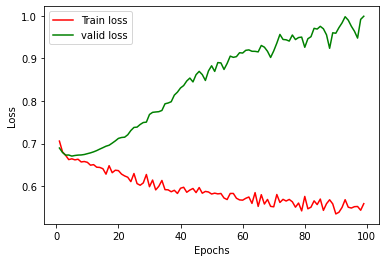

In [21]:
import matplotlib.pyplot as plt

plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i  in epoch_loss],label="Train loss",color="Red",)
plt.plot([i for i in range(1,epochs)],[j.cpu().detach().numpy() for j in valida_loss],label="valid loss",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

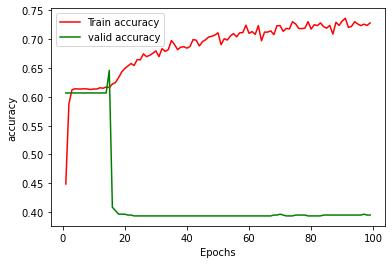

In [22]:
plt.plot([i for i in range(1,epochs)],[i  for i  in traine_accuracy],label="Train accuracy",color="Red",)
plt.plot([i for i in range(1,epochs)],[j for j in vale_accuracy],label="valid accuracy",color="Green")
#plt.plot([i for i in range(1,epochs)],[i.cpu().detach().numpy() for i in test_loss],label="Test loss",color="Blue")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.show()

In [86]:
print(f"Training loss|   Mean: {torch.tensor(epoch_loss).mean()}   std: {torch.tensor(epoch_loss).std()}")
print(f"validation loss| Mean: {torch.tensor(valida_loss).mean()}  std: {torch.tensor(valida_loss).std()}")
print(f"Test loss|       Mean: {torch.tensor(test_loss).mean()}   std: {torch.tensor(test_loss).std()}")

Training loss|   Mean: 0.58771812915802   std: 0.03894892334938049
validation loss| Mean: 0.60456383228302  std: 0.038489241153001785
Test loss|       Mean: 0.5889618396759033   std: nan


C:\Users\Y-8874~1.EST\AppData\Local\Temp/ipykernel_8700/2757444226.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(f"Test loss|       Mean: {torch.tensor(test_loss).mean()}   std: {torch.tensor(test_loss).std()}")
